In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)

trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, not_nn_loss_weight=100, and_nn_loss_weight=100)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 2001/2000 | loss 5.5413 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 35.92s
train epoch 01/10 | batch 2001/2000 | loss 4.2186 | val loss 0.5406 | acc 0.7973 | f1 0.0939 | prec 0.9882 | recall 0.0493 | roc auc 0.5050 | pr auc 0.2769 | elapsed 81.55s
train epoch 02/10 | batch 2001/2000 | loss 3.2381 | val loss 0.4757 | acc 0.8170 | f1 0.2504 | prec 0.9859 | recall 0.1434 | roc auc 0.6426 | pr auc 0.4489 | elapsed 81.50s
train epoch 03/10 | batch 2001/2000 | loss 3.0531 | val loss 0.4451 | acc 0.8246 | f1 0.3334 | prec 0.8764 | recall 0.2059 | roc auc 0.7127 | pr auc 0.5198 | elapsed 78.81s
train epoch 04/10 | batch 2001/2000 | loss 2.9861 | val loss 0.4024 | acc 0.8378 | f1 0.4529 | prec 0.8057 | recall 0.3150 | roc auc 0.7827 | pr auc 0.6153 | elapsed 83.59s
train epoch 05/10 | batch 2001/2000 | loss 2.9087 |

In [4]:
not_nn = trained_reasoner.not_nn
top = trained_reasoner.top_concept[0]
bot = trained_reasoner.bot_concept[0]
optimizer = T.optim.AdamW(not_nn.parameters(), 0.0001)

for i in range(20000):
    optimizer.zero_grad()
    input1 = T.rand(10)

    loss = (F.mse_loss(input1, not_nn(not_nn(input1))))
    loss+=(F.mse_loss(top, not_nn(bot)))
    loss+=(F.mse_loss(bot, not_nn(top)))

    if i%5000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

trained_reasoner.not_nn = not_nn

loss:  tensor(0.7034, grad_fn=<AddBackward0>)
loss:  tensor(0.0073, grad_fn=<AddBackward0>)
loss:  tensor(0.0005, grad_fn=<AddBackward0>)
loss:  tensor(1.7021e-09, grad_fn=<AddBackward0>)


In [5]:
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=5, batch_size=batch_size, not_nn_loss_weight=100, top_bot_weight=15, and_nn_loss_weight=100)

train epoch 0/5 | batch 2001/2000 | loss 2.5238 | val loss 0.2304 | acc 0.9218 | f1 0.8016 | prec 0.8729 | recall 0.7411 | roc auc 0.9305 | pr auc 0.8798 | elapsed 63.09s
train epoch 1/5 | batch 2001/2000 | loss 2.4681 | val loss 0.2034 | acc 0.9326 | f1 0.8276 | prec 0.9103 | recall 0.7587 | roc auc 0.9432 | pr auc 0.9004 | elapsed 82.51s
train epoch 2/5 | batch 2001/2000 | loss 2.4242 | val loss 0.1977 | acc 0.9351 | f1 0.8363 | prec 0.9045 | recall 0.7777 | roc auc 0.9473 | pr auc 0.9083 | elapsed 89.46s
train epoch 3/5 | batch 2001/2000 | loss 2.4411 | val loss 0.1960 | acc 0.9379 | f1 0.8446 | prec 0.9054 | recall 0.7915 | roc auc 0.9499 | pr auc 0.9132 | elapsed 89.26s
train epoch 4/5 | batch 2001/2000 | loss 2.4649 | val loss 0.1963 | acc 0.9381 | f1 0.8473 | prec 0.8928 | recall 0.8062 | roc auc 0.9520 | pr auc 0.9165 | elapsed 90.10s
train epoch 5/5 | batch 2001/2000 | loss 2.4898 | val loss 0.2005 | acc 0.9365 | f1 0.8456 | prec 0.8774 | recall 0.8161 | roc auc 0.9534 | pr au

In [24]:
torch.set_printoptions(precision=3)
input = T.rand(10)
print(input)
output = trained_reasoner.not_nn(trained_reasoner.not_nn(input))
print(output)
print(F.mse_loss(input, output))

tensor([0.390, 0.389, 0.362, 0.807, 0.578, 0.434, 0.065, 0.987, 0.030, 0.100])
tensor([0.392, 0.387, 0.361, 0.809, 0.579, 0.437, 0.071, 0.990, 0.030, 0.099],
       grad_fn=<SqueezeBackward3>)
tensor(6.351e-06, grad_fn=<MseLossBackward0>)


In [19]:
trained_reasoner.not_nn.weight

Parameter containing:
tensor([[-0.293,  0.175,  0.611, -0.016,  0.172, -0.124,  0.485,  0.703,  0.050,
          0.310],
        [ 0.021, -0.544, -0.063,  0.082,  0.113,  0.553, -0.040, -0.042,  0.719,
         -0.003],
        [ 0.398, -0.176,  0.014,  0.679, -0.152, -0.337, -0.029,  0.413,  0.354,
         -0.088],
        [-0.081, -0.062,  0.386, -0.232,  0.261, -0.340,  0.113, -0.393,  0.203,
         -0.499],
        [ 0.416,  0.483, -0.017,  0.058,  0.038, -0.217,  0.853, -0.257,  0.167,
          0.206],
        [-0.008,  0.719, -0.477, -0.347, -0.054,  0.027,  0.310,  0.303,  0.159,
         -0.377],
        [ 0.232,  0.402, -0.258, -0.100,  0.727, -0.099,  0.023, -0.068, -0.589,
         -0.348],
        [ 0.578,  0.146,  0.465, -0.337, -0.512,  0.373,  0.207,  0.185, -0.194,
          0.112],
        [ 0.057,  0.365,  0.269,  0.376,  0.085,  0.455, -0.419, -0.155,  0.363,
          0.281],
        [ 0.234, -0.182, -0.265, -0.719,  0.379, -0.416, -0.243, -0.170,  0.235,
      

In [21]:
print(T.round(T.matmul( trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100)

tensor([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000, -0.000, 0.000, 0.000, 0.000],
        [0.000, 1.000, -0.000, -0.000, 0.000, -0.000, 0.000, 0.000, 0.000, -0.000],
        [0.000, -0.000, 1.000, -0.000, 0.000, -0.000, 0.000, 0.000, 0.000, -0.000],
        [0.000, 0.000, 0.000, 1.000, -0.000, 0.000, 0.000, -0.000, -0.000, 0.000],
        [0.000, 0.000, -0.000, 0.000, 1.000, -0.000, 0.000, 0.000, 0.000, -0.000],
        [0.000, 0.000, 0.000, 0.000, -0.000, 1.000, -0.000, -0.000, 0.000, 0.000],
        [0.000, 0.000, 0.010, 0.000, -0.000, 0.000, 1.000, -0.000, -0.000, 0.000],
        [0.000, 0.000, 0.000, 0.000, -0.000, 0.000, -0.000, 1.000, 0.000, 0.000],
        [-0.000, 0.000, 0.000, -0.000, -0.000, 0.000, -0.000, -0.000, 1.000, 0.000],
        [-0.000, 0.000, 0.000, 0.000, -0.000, 0.000, -0.000, -0.000, -0.000, 1.000]],
       grad_fn=<DivBackward0>)


In [25]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.687,  0.172,  0.221, -0.380,  0.659, -0.035,  0.145,  0.196, -0.333,
        -0.415], grad_fn=<SelectBackward0>)
tensor([ 0.583,  0.189,  0.094, -0.426,  0.576, -0.169,  0.123,  0.091, -0.390,
        -0.379], grad_fn=<SqueezeBackward3>)
tensor(0.007, grad_fn=<MseLossBackward0>)


In [26]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.035, -0.446, -0.189,  0.370,  0.305,  0.345,  1.021,  0.270, -0.375,
         0.375], grad_fn=<SelectBackward0>)
tensor([ 0.151, -0.322, -0.104,  0.370,  0.308,  0.316,  1.022,  0.387, -0.271,
         0.286], grad_fn=<SqueezeBackward3>)
tensor(0.007, grad_fn=<MseLossBackward0>)


In [11]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, not_nn_loss_weight=0.1)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.1914 | val loss 1.1914 | acc 0.6398 | f1 0.3966 | prec 0.3119 | recall 0.5446 | roc auc 0.6536 | pr auc 0.4866 | elapsed 25.38s
train epoch 01/10 | batch 1251/1250 | loss 1.0051 | val loss 0.7907 | acc 0.7296 | f1 0.4763 | prec 0.4113 | recall 0.5657 | roc auc 0.7343 | pr auc 0.5610 | elapsed 45.72s
train epoch 02/10 | batch 1251/1250 | loss 0.6722 | val loss 0.5278 | acc 0.8038 | f1 0.5734 | prec 0.5436 | recall 0.6066 | roc auc 0.8148 | pr auc 0.6607 | elapsed 45.01s
train epoch 03/10 | batch 1251/1250 | loss 0.4612 | val loss 0.3700 | acc 0.8616 | f1 0.6756 | prec 0.6889 | recall 0.6628 | roc auc 0.8780 | pr auc 0.7616 | elapsed 44.92s
train epoch 04/10 | batch 1251/1250 | loss 0.3351 | val loss 0.2766 | acc 0.8989 | f1 0.7548 | prec 0.7978 | recall 0.7163 | roc auc 0.9196 | pr auc 0.8384 | elapsed 44.10s
train epoch 05/10 | batch 1251/1250 | loss 0.2593 | val loss 0.2194 | acc 0.9213 | f1 0.8067 | prec 0.8650 | recall 0.

In [12]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240630T132747


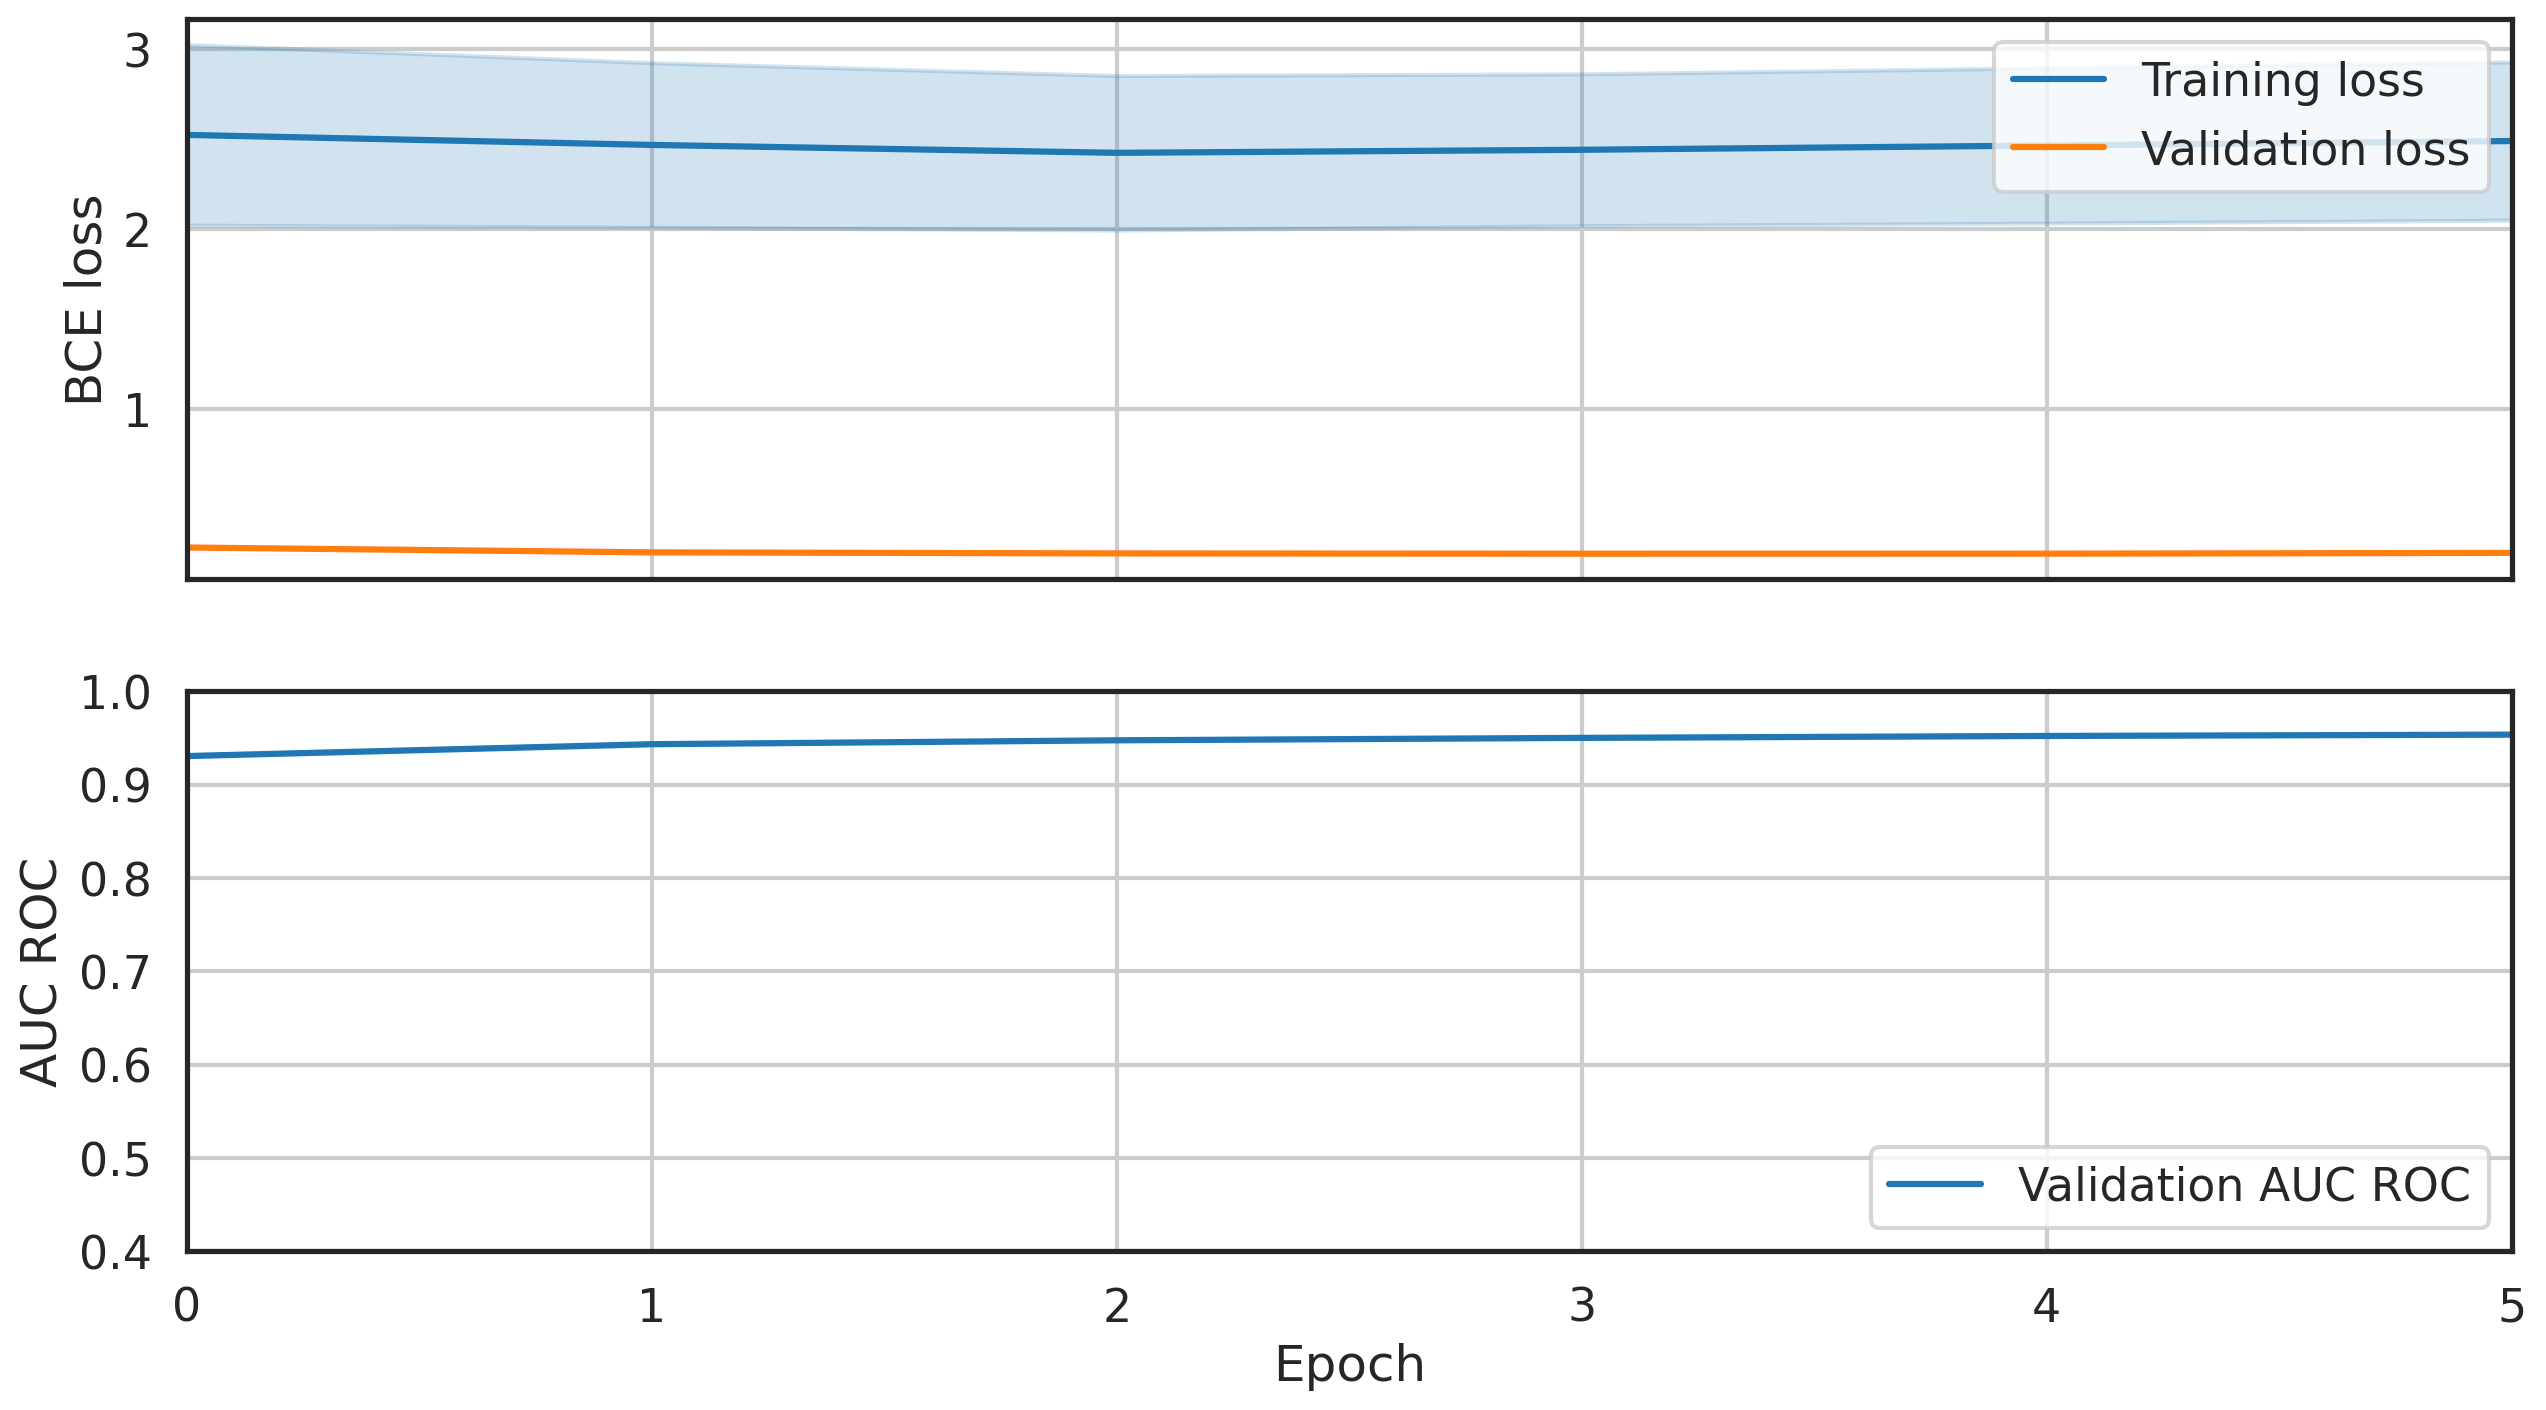

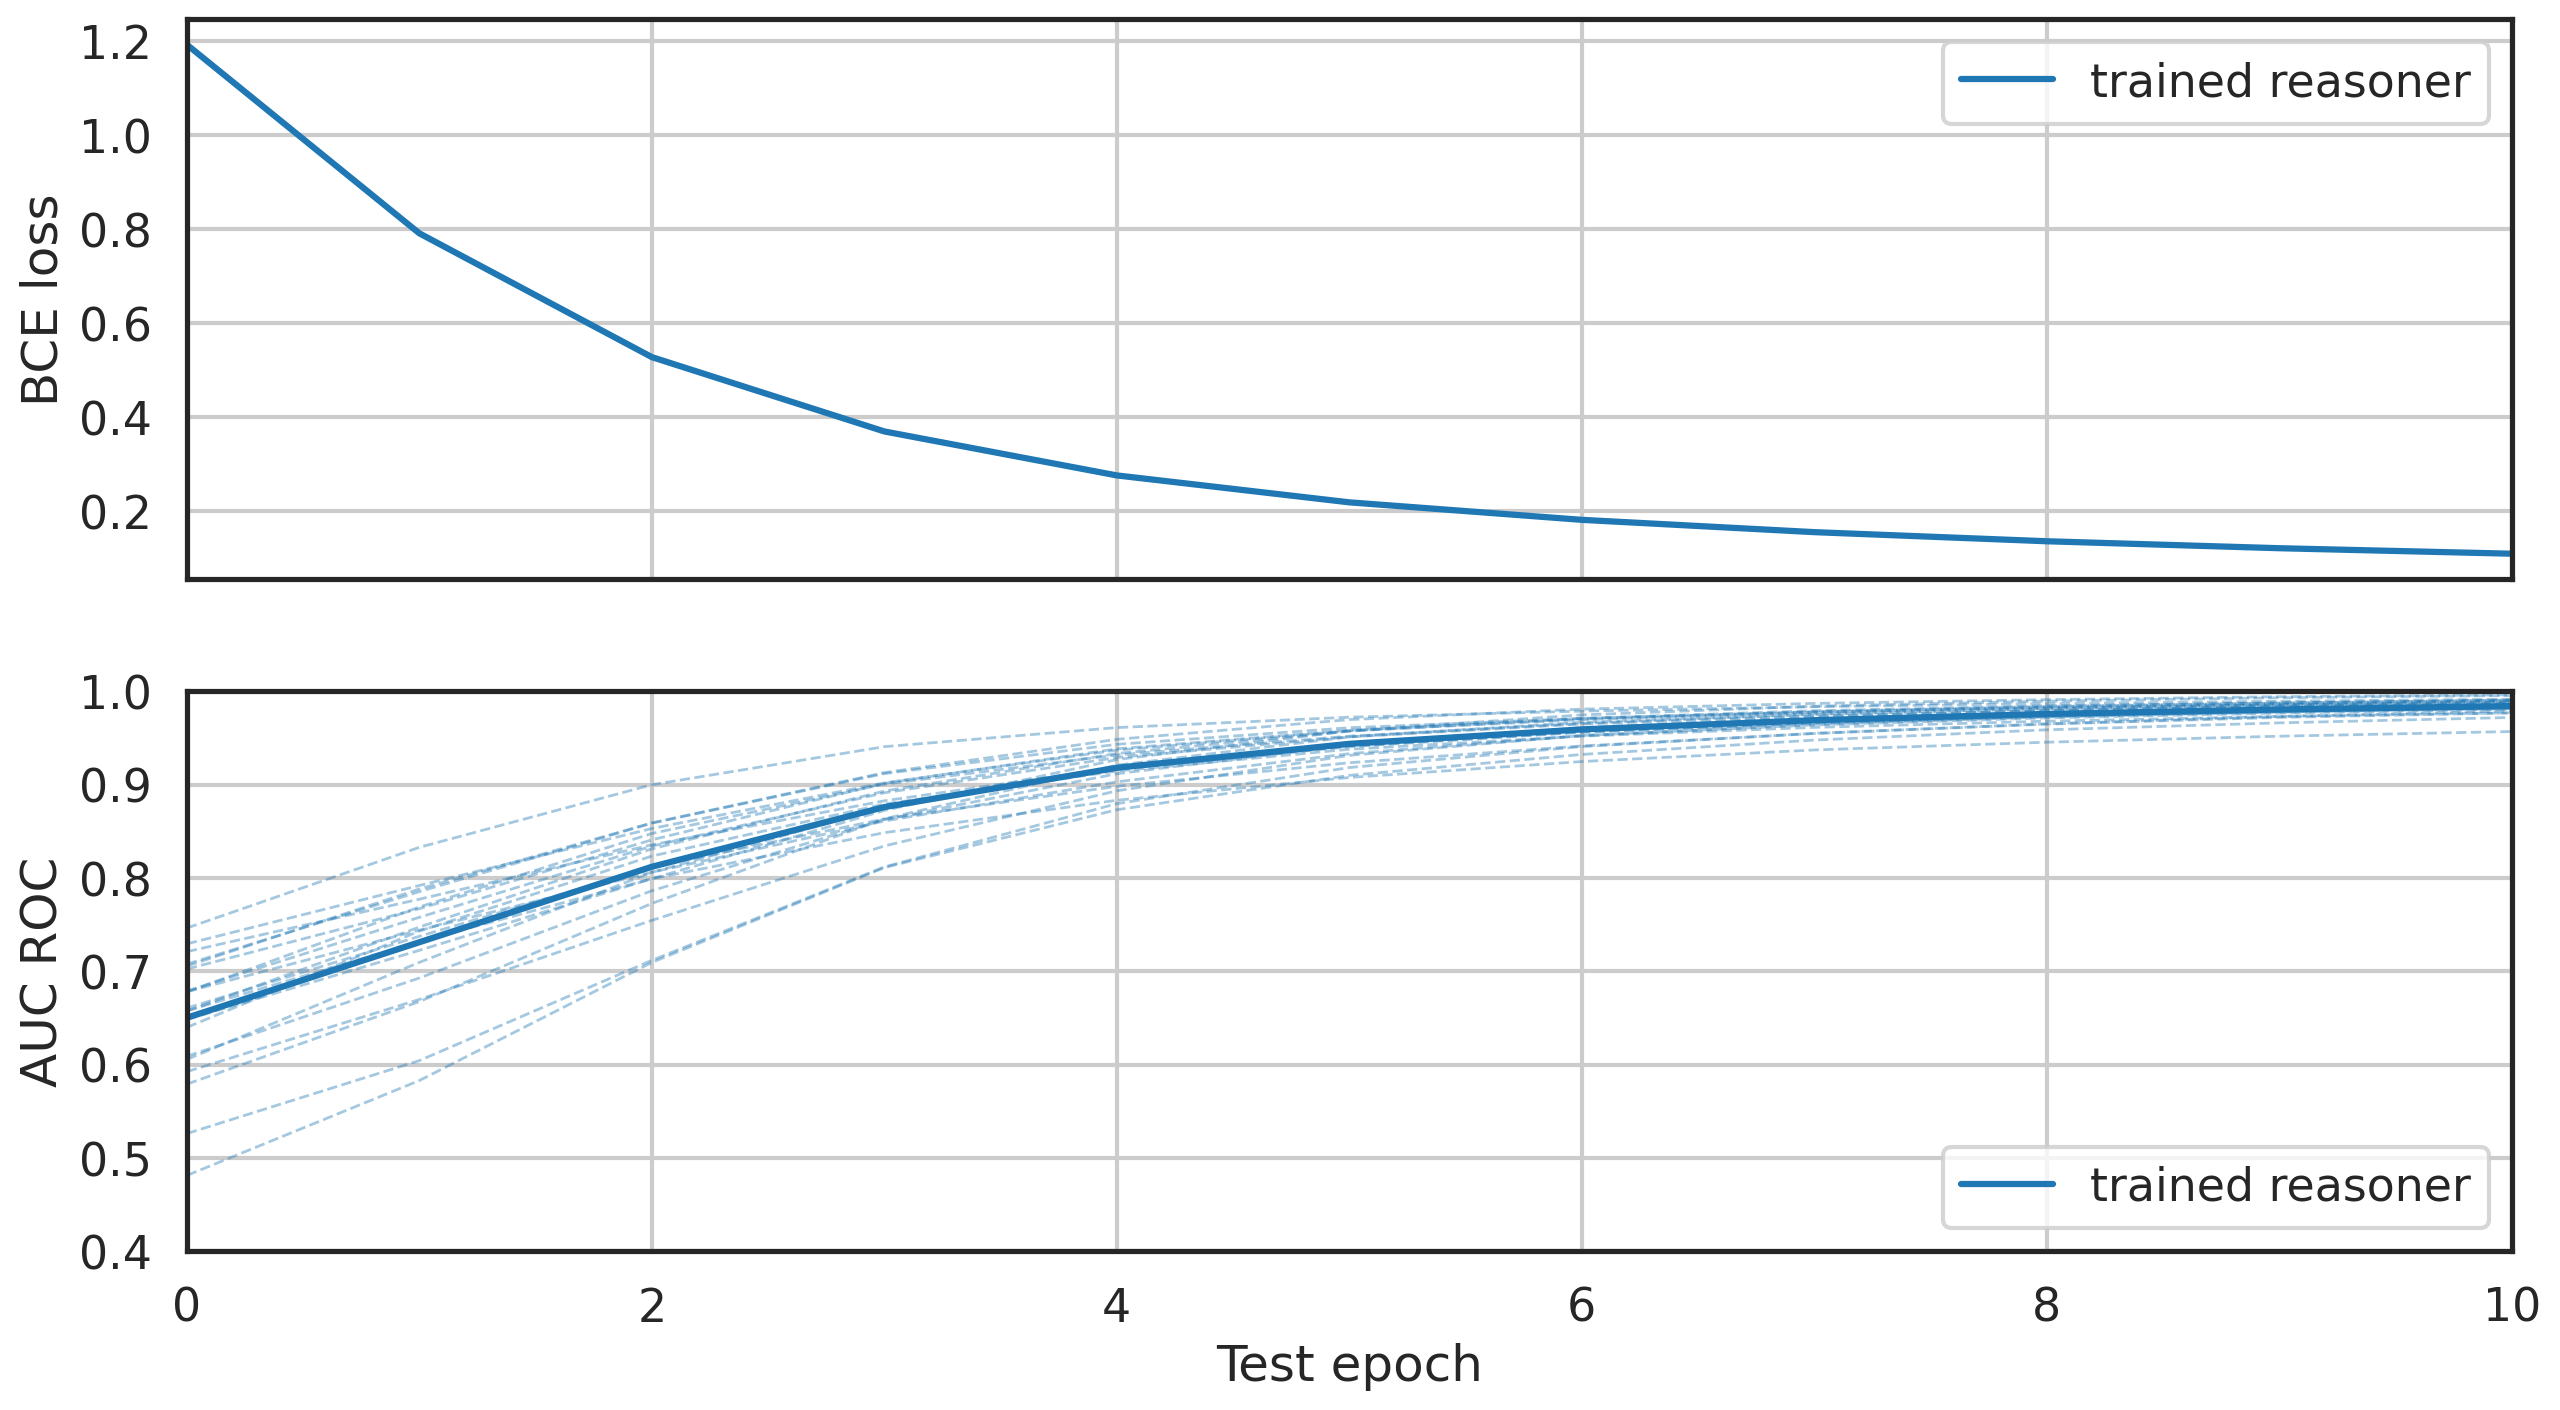

             mean       std     micro
acc      0.962475  0.016650  0.962475
prec     0.960518  0.029515  0.960568
recall   0.860946  0.051535  0.862810
f1       0.907641  0.039829  0.909069
auc_roc  0.983997  0.009088  0.985008
auc_pr   0.964191  0.018607  0.966701


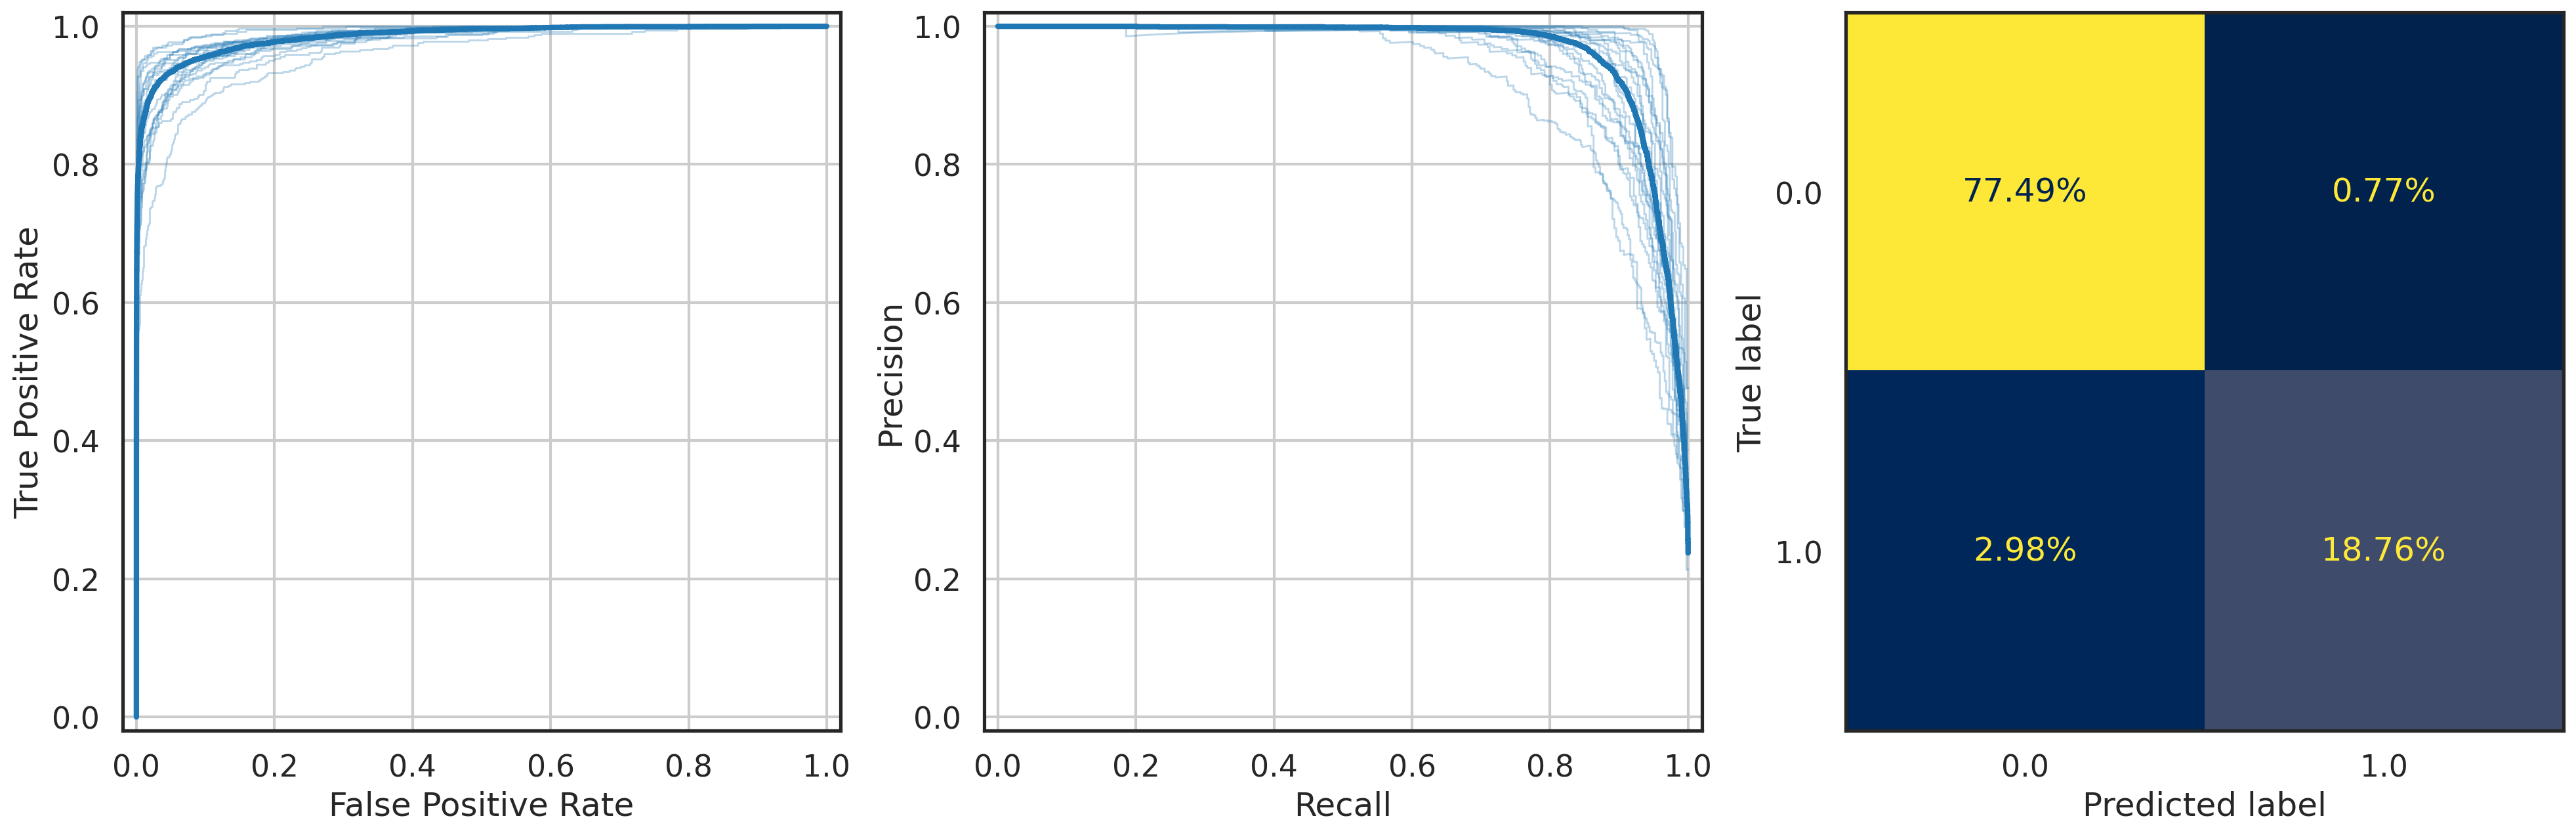

In [13]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [14]:
print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
F.mse_loss(input, trained_reasoner.and_nn(im_mod(input, input)))

tensor([0.5004, 0.8690, 0.7334, 0.0686, 0.5887, 0.8380, 0.7090, 0.1592, 0.2602,
        0.3526])
tensor([ 0.4010,  0.5205, -0.4064, -0.3080,  0.0521,  0.3654,  0.6636,  0.3631,
        -0.3796, -0.6685], grad_fn=<AddBackward0>)


tensor(0.3579, grad_fn=<MseLossBackward0>)

In [15]:
print(input)
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]))

tensor([0.5004, 0.8690, 0.7334, 0.0686, 0.5887, 0.8380, 0.7090, 0.1592, 0.2602,
        0.3526])
tensor([ 0.6872,  0.1715,  0.2212, -0.3805,  0.6586, -0.0355,  0.1451,  0.1961,
        -0.3330, -0.4153], grad_fn=<SelectBackward0>)
tensor([ 0.1656,  0.3199,  0.0246, -0.3040,  0.1372,  0.0090,  0.3312,  0.0875,
        -0.3308, -0.2380], grad_fn=<AddBackward0>)
tensor(0.0690, grad_fn=<MseLossBackward0>)


In [16]:
print(input)
print(trained_reasoner.top_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input))


tensor([0.5004, 0.8690, 0.7334, 0.0686, 0.5887, 0.8380, 0.7090, 0.1592, 0.2602,
        0.3526])
tensor([ 0.0349, -0.4462, -0.1888,  0.3701,  0.3051,  0.3452,  1.0212,  0.2701,
        -0.3750,  0.3748], grad_fn=<SelectBackward0>)
tensor([ 0.4529,  0.1519, -0.0549, -0.2180,  0.0223,  0.5135,  0.6301,  0.4610,
        -0.2001, -0.2449], grad_fn=<AddBackward0>)
tensor(0.2312, grad_fn=<MseLossBackward0>)
